# 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Dataset


In [2]:
df = pd.read_csv("StudentPerformanceFactors.csv")

# 3. Inspect & Clean


In [3]:
target = "Exam_Score"
df = df.dropna(subset=[target])

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols:
    num_cols.remove(target)

# Fill missing
df[cat_cols] = df[cat_cols].fillna('Unknown')
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# 4. Feature Sets


In [4]:
simple_features = ["Hours_Studied"]
extended_numeric = ["Hours_Studied", "Previous_Scores", "Attendance", "Sleep_Hours", "Tutoring_Sessions", "Physical_Activity"]
full_features = [c for c in df.columns if c != target]

y = df[target]

# 5. Train & Evaluate Function

In [5]:
results = []

def train_and_evaluate(X, y, preprocess, model, desc):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({"Model": desc, "MAE": mae, "RMSE": rmse, "R²": r2})
    return pipe, X_test, y_test, preds

# 6. Models

#### 1) Simple Linear Regression

In [6]:
preproc_simple = ColumnTransformer([("num", StandardScaler(), simple_features)])
_, X_test_s, y_test_s, preds_s = train_and_evaluate(
    df[simple_features], y, preproc_simple, LinearRegression(), "LinearReg - Hours_Studied")

#### 2) Extended numeric features

In [7]:
preproc_ext = ColumnTransformer([("num", StandardScaler(), extended_numeric)])
_, X_test_e, y_test_e, preds_e = train_and_evaluate(
    df[extended_numeric], y, preproc_ext, LinearRegression(), "LinearReg - Extended Numeric")

#### 3) Full features

In [8]:
full_cat = [c for c in cat_cols if c in full_features]
full_num = [c for c in num_cols if c in full_features]
preproc_full = ColumnTransformer([
    ("num", StandardScaler(), full_num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), full_cat)
])
full_model, X_test_f, y_test_f, preds_f = train_and_evaluate(
    df[full_features], y, preproc_full, LinearRegression(), "LinearReg - Full Features")

#### 4) Polynomial Regression (degree 2)

In [9]:
poly_preproc2 = ColumnTransformer([
    ("poly", Pipeline([("polyfeat", PolynomialFeatures(degree=2, include_bias=False)), ("sc", StandardScaler())]), simple_features)
])
_, X_test_p2, y_test_p2, preds_p2 = train_and_evaluate(
    df[simple_features], y, poly_preproc2, LinearRegression(), "PolyDeg2 - Hours_Studied")

#### 5) Polynomial Regression (degree 3)

In [10]:
poly_preproc3 = ColumnTransformer([
    ("poly", Pipeline([("polyfeat", PolynomialFeatures(degree=3, include_bias=False)), ("sc", StandardScaler())]), simple_features)
])
_, X_test_p3, y_test_p3, preds_p3 = train_and_evaluate(
    df[simple_features], y, poly_preproc3, LinearRegression(), "PolyDeg3 - Hours_Studied"
)

# 7. Metrics Table


In [11]:
metrics_df = pd.DataFrame(results)
print("\nModel Performance:\n", metrics_df)


Model Performance:
                           Model       MAE      RMSE        R²
0     LinearReg - Hours_Studied  2.447569  3.294833  0.231987
1  LinearReg - Extended Numeric  1.265856  2.250657  0.641639
2     LinearReg - Full Features  0.449950  1.803353  0.769928
3      PolyDeg2 - Hours_Studied  2.444780  3.293173  0.232760
4      PolyDeg3 - Hours_Studied  2.444512  3.292998  0.232842


# 8. Plot: Actual vs Predicted


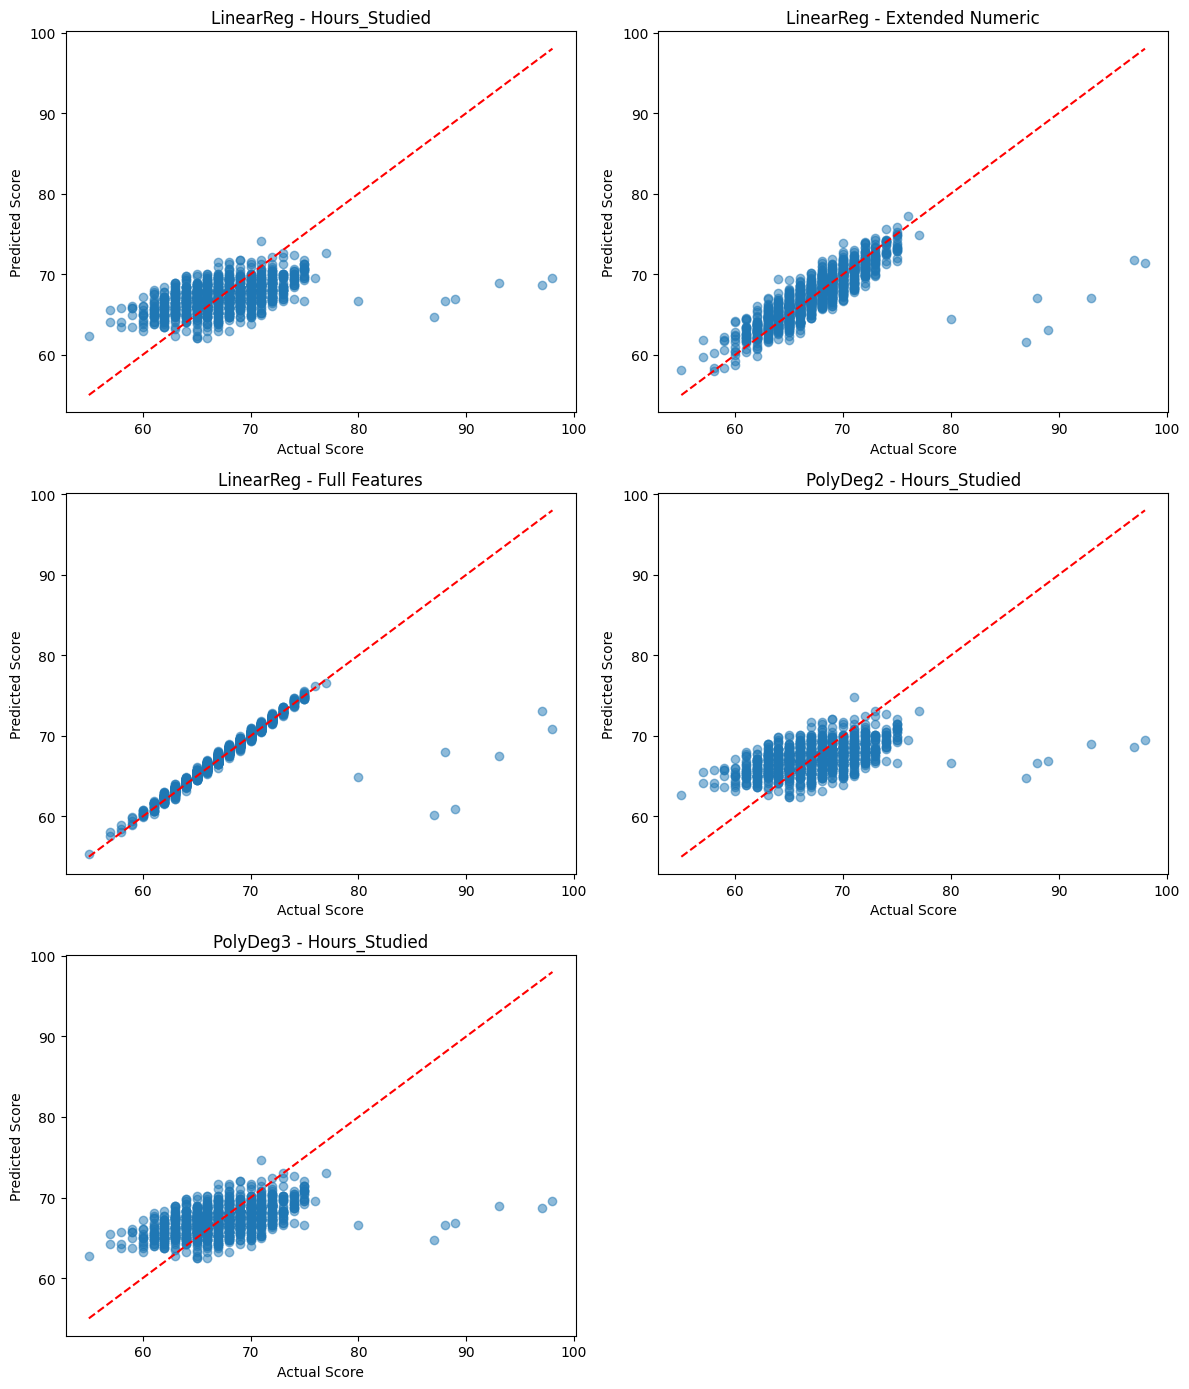

In [12]:
model_preds = [
    ("LinearReg - Hours_Studied", y_test_s, preds_s),
    ("LinearReg - Extended Numeric", y_test_e, preds_e),
    ("LinearReg - Full Features", y_test_f, preds_f),
    ("PolyDeg2 - Hours_Studied", y_test_p2, preds_p2),
    ("PolyDeg3 - Hours_Studied", y_test_p3, preds_p3)
]

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.ravel()

for ax, (title, y_t, y_p) in zip(axes, model_preds):
    ax.scatter(y_t, y_p, alpha=0.5)
    ax.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'r--')
    ax.set_title(title)
    ax.set_xlabel("Actual Score")
    ax.set_ylabel("Predicted Score")

# Remove any unused subplot
for i in range(len(model_preds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 9. Bar Charts: MAE & RMSE


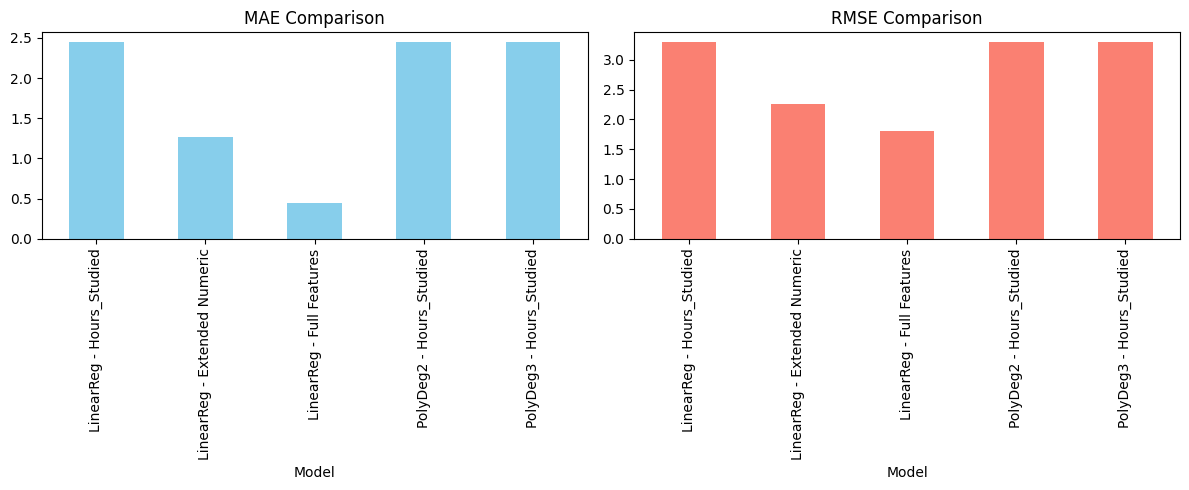

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
metrics_df.plot.bar(x="Model", y="MAE", ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("MAE Comparison")
metrics_df.plot.bar(x="Model", y="RMSE", ax=axes[1], color="salmon", legend=False)
axes[1].set_title("RMSE Comparison")
plt.tight_layout()
plt.show()

# 10. Feature Importance (Full Model)


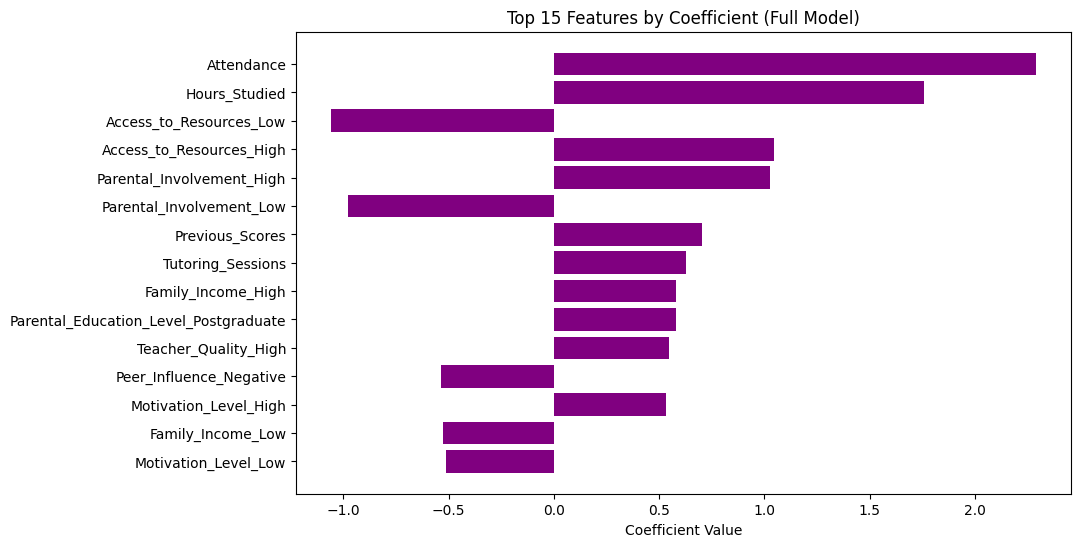

In [14]:
# Extract feature names after preprocessing
ohe = full_model.named_steps["preprocess"].named_transformers_["cat"]
encoded_cat_features = ohe.get_feature_names_out(full_cat)
all_features = np.concatenate([full_num, encoded_cat_features])

coefs = full_model.named_steps["model"].coef_

# Plot top 15
coef_df = pd.DataFrame({"Feature": all_features, "Coefficient": coefs})
coef_df["AbsCoef"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("AbsCoef", ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="purple")
plt.gca().invert_yaxis()
plt.title("Top 15 Features by Coefficient (Full Model)")
plt.xlabel("Coefficient Value")
plt.show()

# Extra: Data Understanding


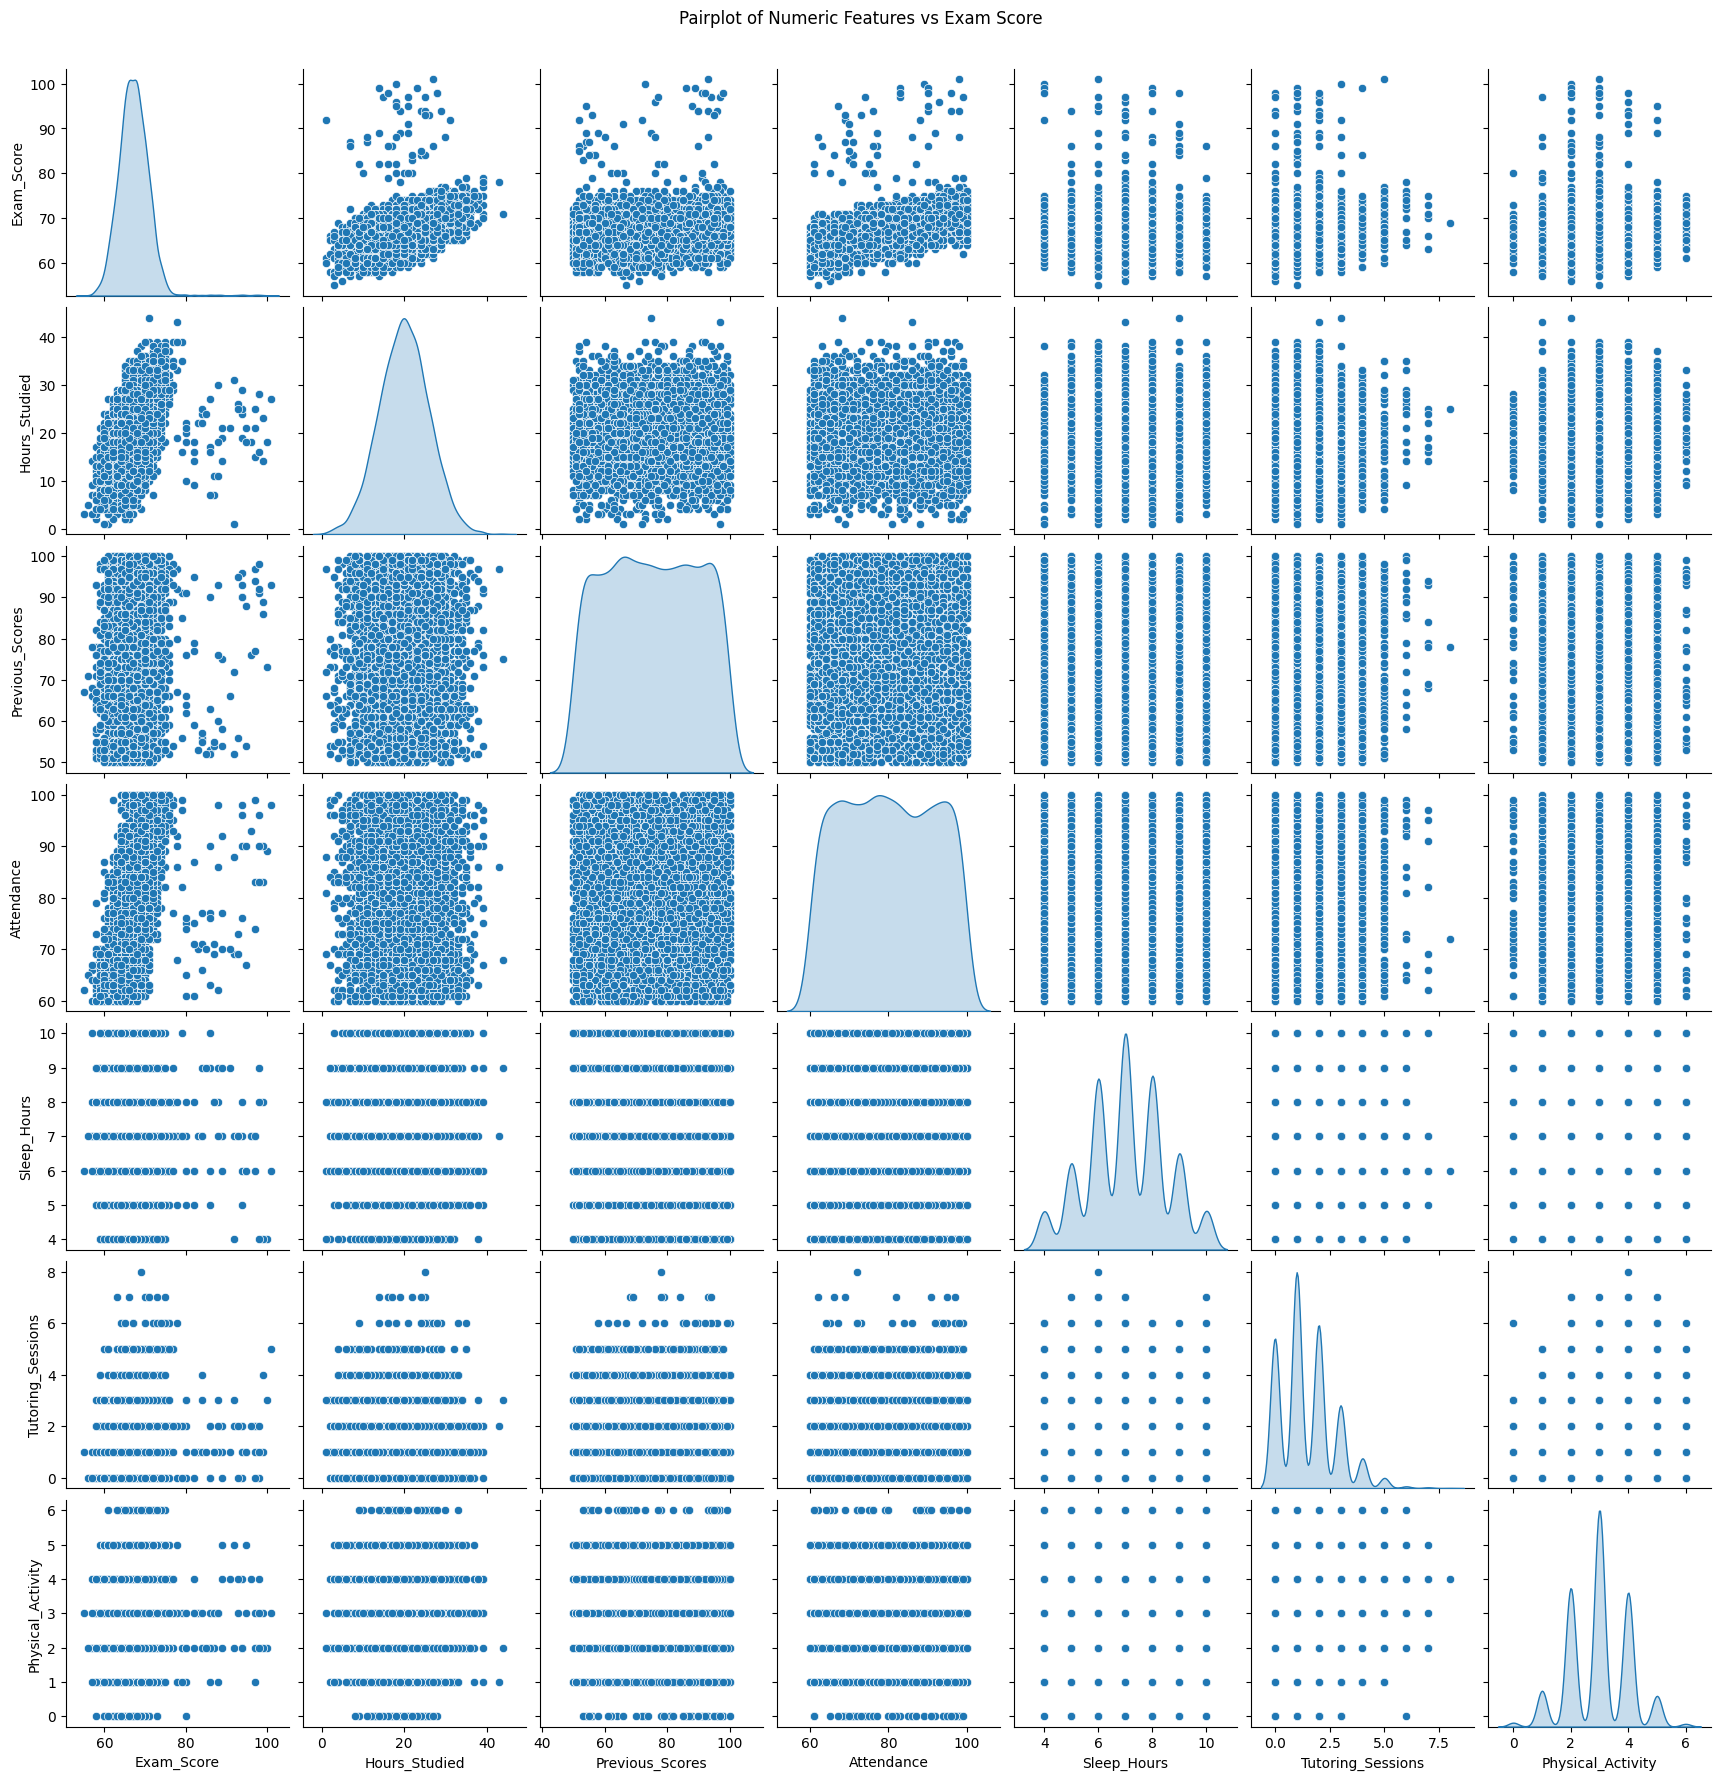

In [16]:
# Pairplot for key numeric features
sns.pairplot(df[[target] + extended_numeric], diag_kind="kde")
plt.suptitle("Pairplot of Numeric Features vs Exam Score", y=1.02)
plt.show()

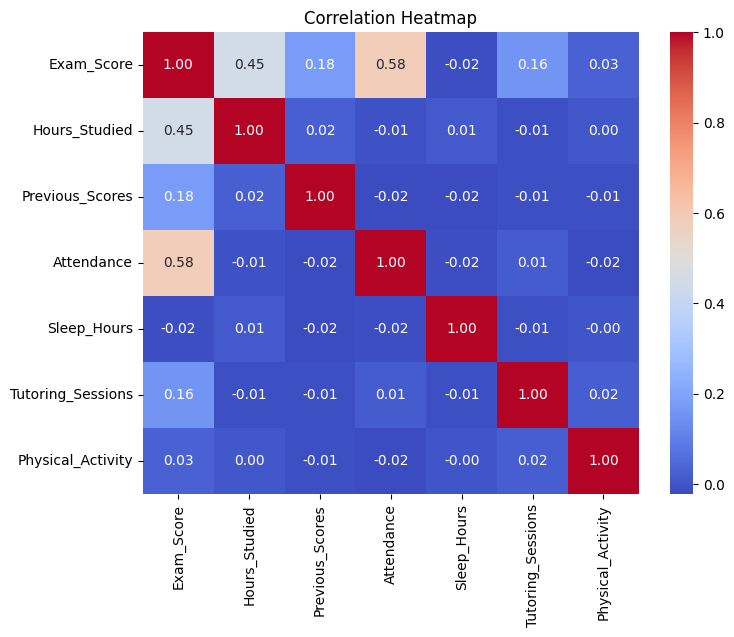

In [17]:
# Correlation heatmap
corr = df[[target] + extended_numeric].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

/tmp/ipython-input-459237582.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, palette="Set2")
/tmp/ipython-input-459237582.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, palette="Set2")
/tmp/ipython-input-459237582.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, palette="Set2")
/tmp/ipython-input-459237582.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

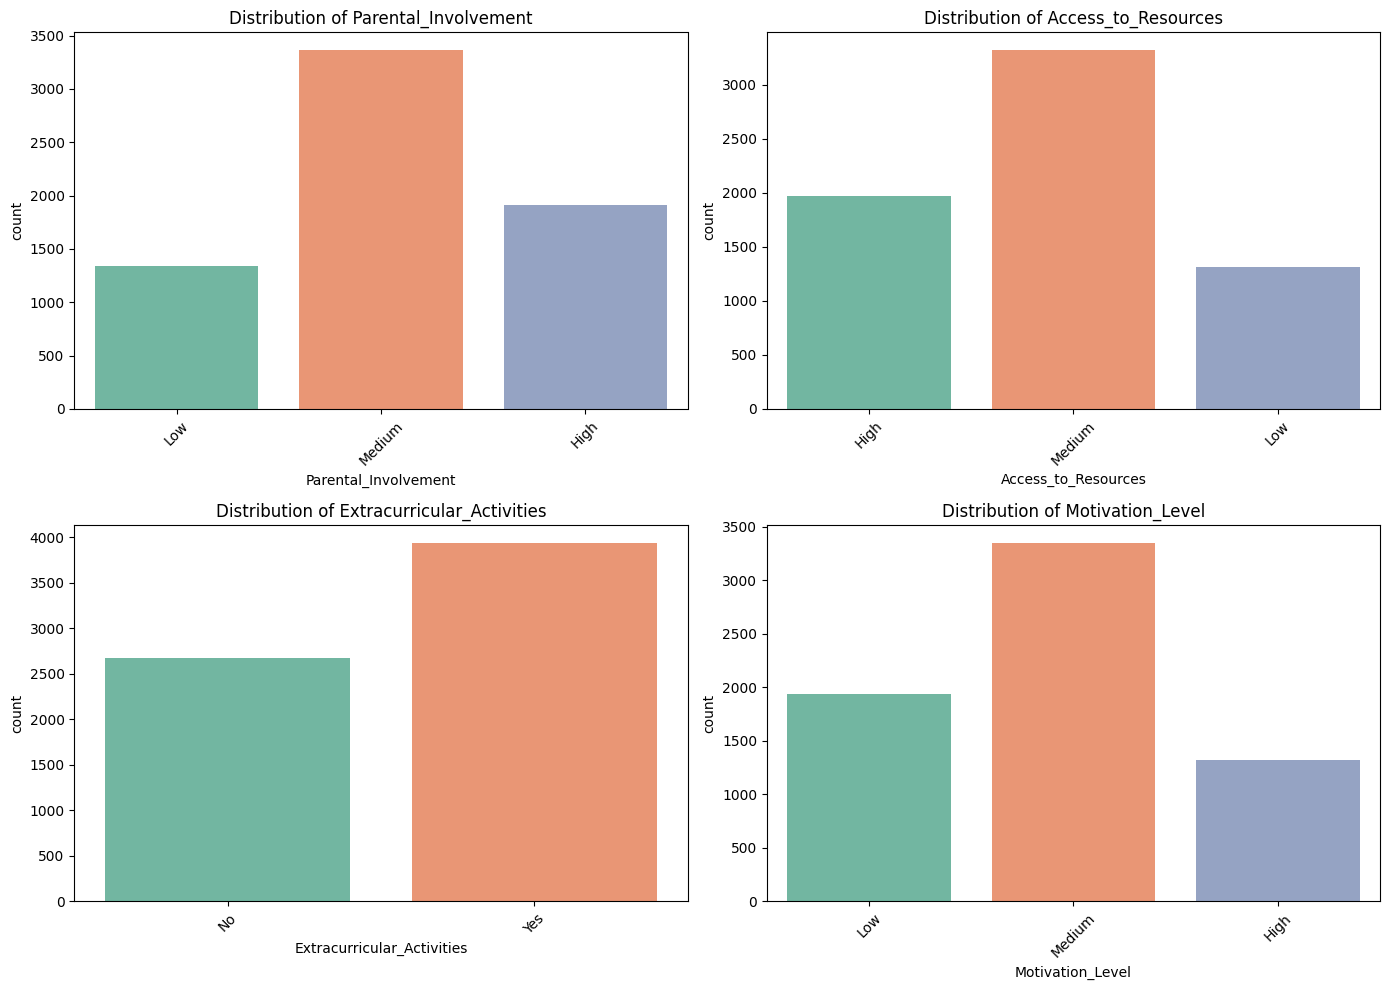

In [18]:
# Count plots for top categorical features
top_cat_for_plot = cat_cols[:4]  # take first 4 just for example
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for ax, col in zip(axes, top_cat_for_plot):
    sns.countplot(data=df, x=col, ax=ax, palette="Set2")
    ax.set_title(f"Distribution of {col}")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Final Summary: Best Model


In [19]:
best_model_row = metrics_df.sort_values(by="R²", ascending=False).iloc[0]
print("=== Best Model Summary ===")
print(f"Model: {best_model_row['Model']}")
print(f"R² Score: {best_model_row['R²']:.4f}")
print(f"MAE: {best_model_row['MAE']:.2f}")
print(f"RMSE: {best_model_row['RMSE']:.2f}")

# Optional: Highlight in table
metrics_df['Best'] = metrics_df['Model'] == best_model_row['Model']
print("\nAll Models with Best Marked:")
print(metrics_df)


=== Best Model Summary ===
Model: LinearReg - Full Features
R² Score: 0.7699
MAE: 0.45
RMSE: 1.80

All Models with Best Marked:
                          Model       MAE      RMSE        R²   Best
0     LinearReg - Hours_Studied  2.447569  3.294833  0.231987  False
1  LinearReg - Extended Numeric  1.265856  2.250657  0.641639  False
2     LinearReg - Full Features  0.449950  1.803353  0.769928   True
3      PolyDeg2 - Hours_Studied  2.444780  3.293173  0.232760  False
4      PolyDeg3 - Hours_Studied  2.444512  3.292998  0.232842  False
